# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [62]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from collections import defaultdict

In [4]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [5]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [110]:
X, y = read_dataset("spam")

<ipython-input-4-c1364a5e16ee>:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(x, dtype=np.str), np.array(y, dtype=np.str)


In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [178]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    
    def fit(self, X, y):
        self.cl_count = Counter(y)
        self.cl_count = {cl : count/y.shape[0] for cl, count in self.cl_count.items()}
        self.cl = {i : cl for i, cl in enumerate(self.cl_count.keys())}
        self.f_dict = {}
        for string, cl in zip(X, y):
            for feat, symb in enumerate(string):
                if feat not in self.f_dict:
                    self.f_dict[feat] = {}
                if symb not in self.f_dict[feat]:
                    self.f_dict[feat][symb] = defaultdict(int)
                self.f_dict[feat][symb][cl] += 1
        for feat, feat_s in self.f_dict.items():
            for symb, symb_cl in feat_s.items():
                self.f_dict[feat][symb] = {cl : count/self.cl_count[cl] for cl, count in symb_cl.items()}
       
        
    def predict(self, X):
        return [self.cl[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        l_proba = np.zeros((X.shape[0], len(self.cl)))
        for feat, string in enumerate(X):
            for cl in range(len(self.cl)):
                l_proba[feat][cl] = np.log(self.cl_count[self.cl[cl]]) + sum([np.log(self.f_dict[feat].get(symb, dict()).get(self.cl[cl], self.alpha)) for feat, symb in enumerate(string)])
        return l_proba

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [197]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        self.voc_limit = voc_limit
        counter = Counter()
        for string in X:
            counter.update(string.split())
        self.BOW = {}
        for ind, (name, c) in enumerate(list(reversed(sorted(counter.items(), key=lambda x: x[1])[-voc_limit:]))):
            self.BOW[name] = ind
        
    def transform(self, X):
        X_trans = np.zeros((X.shape[0], self.voc_limit))
        for feat, string in enumerate(X):
            for word in string.split():
                trans = self.BOW.get(word, -1)
                if trans != -1:
                    X_trans[feat][trans] += 1
        return X_trans

In [220]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [221]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9794238683127572, 'spam': 0.9444444444444444},
 {'ham': 0.9916666666666667, 'spam': 0.8717948717948718},
 0.974910394265233)

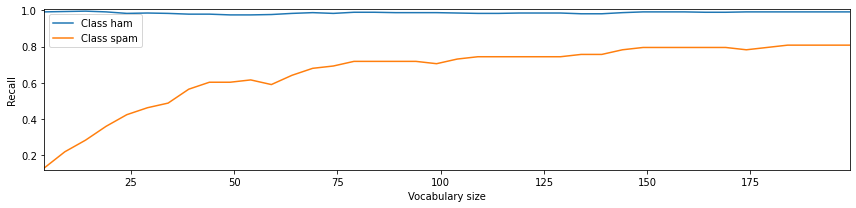

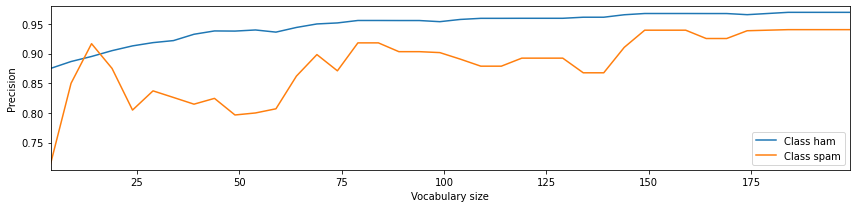

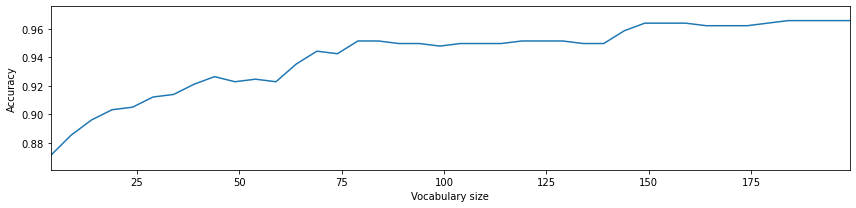

In [222]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [216]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.stemmer = SnowballStemmer('english')
        self.voc_limit = voc_limit
        counter = Counter()
        for string in X:
            counter.update([self.stemmer.stem(w) for w in string.split()])
        self.BOW = {}
        for ind, (name, c) in enumerate(list(reversed(sorted(counter.items(), key=lambda x: x[1])[-voc_limit:]))):
            self.BOW[name] = ind
        
    def transform(self, X):
        X_trans = np.zeros((X.shape[0], self.voc_limit))
        for feat, string in enumerate(X):
            for word in [self.stemmer.stem(w) for w in string.split()]:
                trans = self.BOW.get(word, -1)
                if trans != -1:
                    X_trans[feat][trans] += 1
        return X_trans

In [217]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [218]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9795501022494888, 'spam': 0.9855072463768116},
 {'ham': 0.9979166666666667, 'spam': 0.8717948717948718},
 0.9802867383512545)

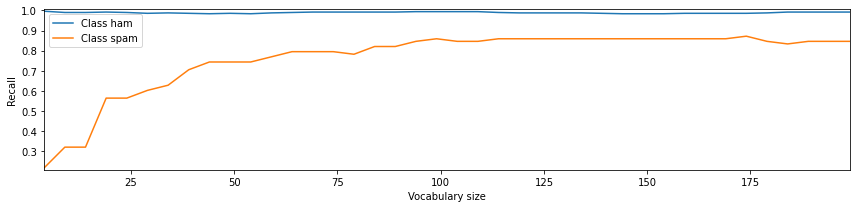

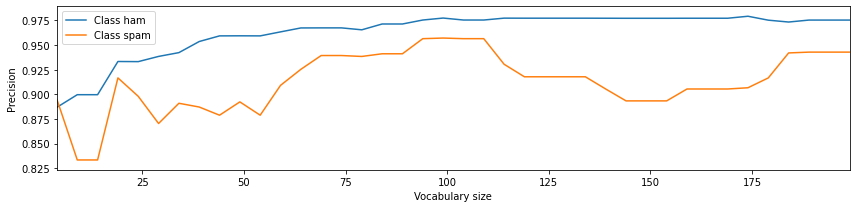

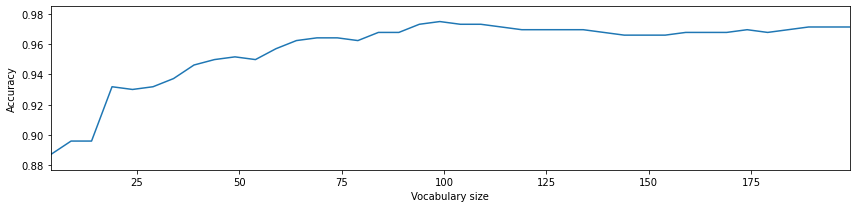

In [219]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)